In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import credentials
import requests

#pulling data API
key =credentials.login['key_isaham']  # extract password

symbol = "XOX"  # which stock to pull
response = requests.get("https://admin.isaham.my/api/chart?stock={}&key={}".format(symbol,key))
data = response.json()

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# makes plots bigger
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

In [3]:
#df= pd.DataFrame.from_dict(data)
df_actual = pd.DataFrame.from_dict(data)

In [4]:
#df_actual

In [5]:
#df = pd.read_csv('greatec.csv')

In [6]:
#df= df[['c','d','h','l','o','v']]
df_actual= df_actual[['c','d','h','l','o','v']]

In [7]:
#df_actual

In [8]:
#df['d'] = pd.to_datetime(df['d'], dayfirst= True )
df_actual['d'] = pd.to_datetime(df_actual['d'], dayfirst= True )

In [9]:
#df_actual

In [10]:
#df.set_index('d',inplace=True,drop=True)
df_actual.set_index('d',inplace=True,drop=True)

In [11]:
#df.index.name = None
df_actual.index.name = None

In [12]:
#df.index
df_actual.index

DatetimeIndex(['2011-06-10', '2011-06-13', '2011-06-14', '2011-06-15',
               '2011-06-16', '2011-06-17', '2011-06-20', '2011-06-21',
               '2011-06-22', '2011-06-23',
               ...
               '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17',
               '2021-03-18', '2021-03-19'],
              dtype='datetime64[ns]', length=2398, freq=None)

In [13]:
split_date = '2020-08-19'
df= df_actual.loc[df_actual.index < split_date].copy()

In [14]:
df

,c,h,l,o,v
2011-06-10,1.0030,1.4081,1.0030,1.4081,16495600.0
2011-06-13,1.0126,1.0416,0.8680,0.9741,9805409.0
2011-06-14,0.9934,1.0512,0.9741,1.0126,3635786.0
2011-06-15,0.9258,1.0030,0.9162,0.9934,1703499.0
2011-06-16,0.8776,0.9066,0.8680,0.9066,5095565.0
...,...,...,...,...,...
2020-08-12,0.2652,0.2990,0.2411,0.2942,371264530.0
2020-08-13,0.2459,0.2749,0.2411,0.2749,353647125.0
2020-08-14,0.2315,0.2508,0.1929,0.2363,607955460.0
2020-08-17,0.1929,0.2315,0.1929,0.2315,427255814.0


In [15]:
#Create the "L14" column in the DataFrame
df['L14'] = df['l'].rolling(window=14).min()

In [16]:
#Create the "H14" column in the DataFrame
df['H14'] = df['h'].rolling(window=14).max()

In [17]:
#Create the "%K" column in the DataFrame
df['%K'] = 100*((df['c'] - df['L14']) / (df['H14'] - df['L14']) )

In [18]:
#Create the "%D" column in the DataFrame
df['%D'] = df['%K'].rolling(window=3).mean()

In [19]:
df.head(5)

,c,h,l,o,v,L14,H14,%K,%D
2011-06-10,1.0030,1.4081,1.0030,1.4081,16495600.0,NaN,NaN,NaN,NaN
2011-06-13,1.0126,1.0416,0.8680,0.9741,9805409.0,NaN,NaN,NaN,NaN
2011-06-14,0.9934,1.0512,0.9741,1.0126,3635786.0,NaN,NaN,NaN,NaN
2011-06-15,0.9258,1.0030,0.9162,0.9934,1703499.0,NaN,NaN,NaN,NaN
2011-06-16,0.8776,0.9066,0.8680,0.9066,5095565.0,NaN,NaN,NaN,NaN


In [20]:
df.tail(5)

,c,h,l,o,v,L14,H14,%K,%D
2020-08-12,0.2652,0.2990,0.2411,0.2942,371264530.0,0.1688,0.3086,68.955651,84.561031
2020-08-13,0.2459,0.2749,0.2411,0.2749,353647125.0,0.1688,0.3086,55.150215,72.628073
2020-08-14,0.2315,0.2508,0.1929,0.2363,607955460.0,0.1736,0.3086,42.888889,55.664918
2020-08-17,0.1929,0.2315,0.1929,0.2315,427255814.0,0.1929,0.3086,0.000000,32.679701
2020-08-18,0.1832,0.1881,0.1688,0.1881,340993392.0,0.1688,0.3086,10.300429,17.729773


Text(0.5, 1.0, 'Oscillator')

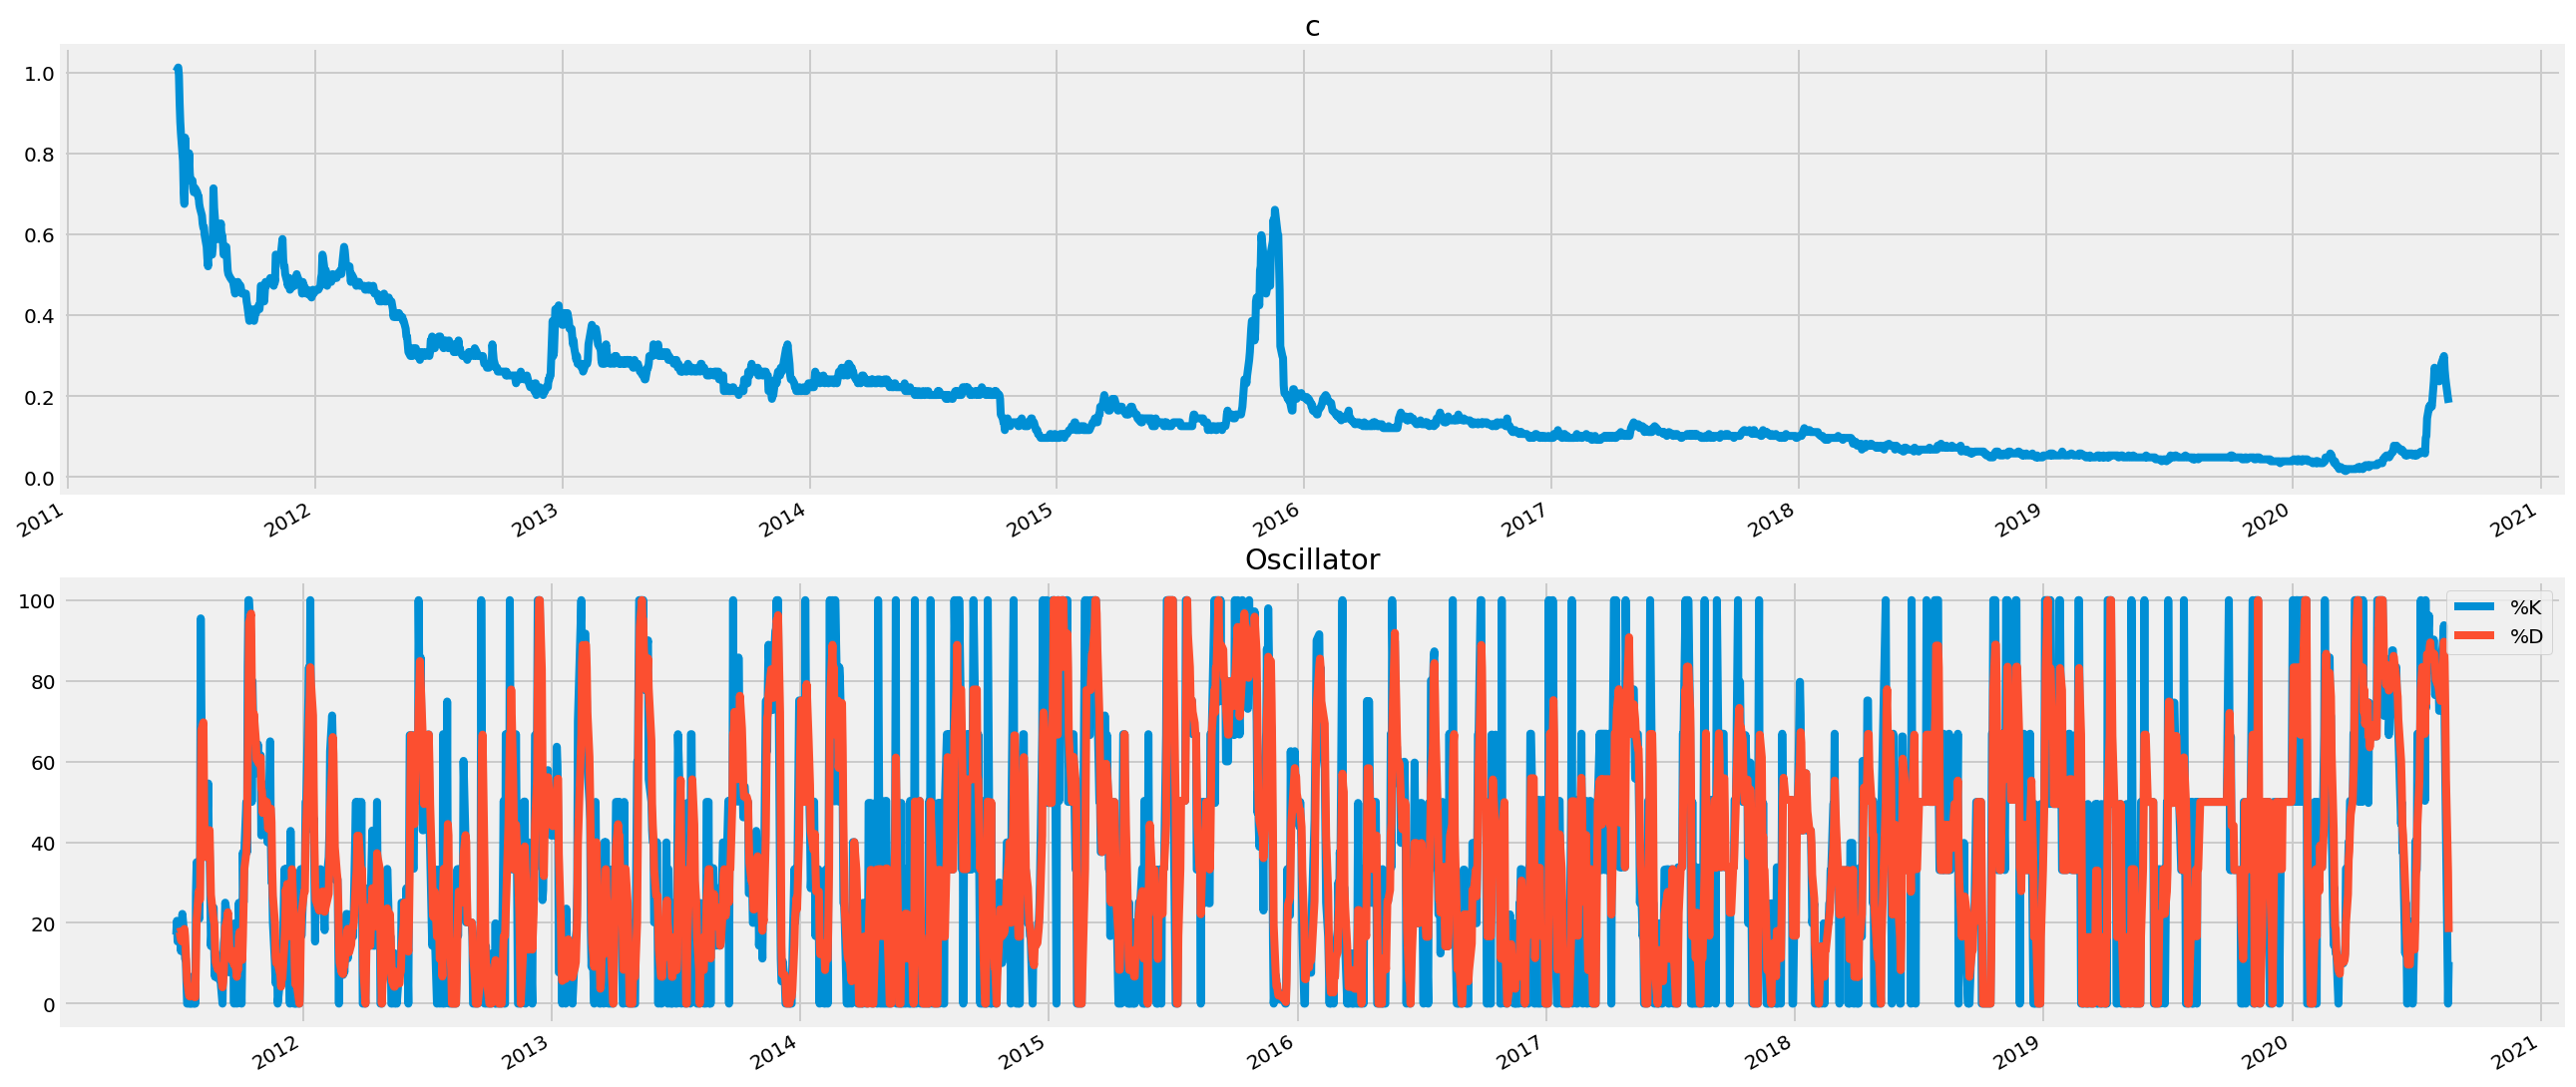

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
df['c'].plot(ax=axes[0]); axes[0].set_title('c')
df[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')

In [22]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
df['Sell OB'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 

In [23]:
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
df['Buy OS'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20) 

In [24]:
df['Strategy'] = np.nan  
df.loc[df['Buy OS'],'Strategy'] = 1  
df.loc[df['Sell OB'],'Strategy'] = 0 

In [25]:
df

,c,h,l,o,v,L14,H14,%K,%D,Sell OB,Buy OS,Strategy
2011-06-10,1.0030,1.4081,1.0030,1.4081,16495600.0,NaN,NaN,NaN,NaN,False,False,NaN
2011-06-13,1.0126,1.0416,0.8680,0.9741,9805409.0,NaN,NaN,NaN,NaN,False,False,NaN
2011-06-14,0.9934,1.0512,0.9741,1.0126,3635786.0,NaN,NaN,NaN,NaN,False,False,NaN
2011-06-15,0.9258,1.0030,0.9162,0.9934,1703499.0,NaN,NaN,NaN,NaN,False,False,NaN
2011-06-16,0.8776,0.9066,0.8680,0.9066,5095565.0,NaN,NaN,NaN,NaN,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,0.2652,0.2990,0.2411,0.2942,371264530.0,0.1688,0.3086,68.955651,84.561031,True,False,0.0
2020-08-13,0.2459,0.2749,0.2411,0.2749,353647125.0,0.1688,0.3086,55.150215,72.628073,False,False,NaN
2020-08-14,0.2315,0.2508,0.1929,0.2363,607955460.0,0.1736,0.3086,42.888889,55.664918,False,False,NaN
2020-08-17,0.1929,0.2315,0.1929,0.2315,427255814.0,0.1929,0.3086,0.000000,32.679701,False,False,NaN


In [27]:
overbought =df['Sell OB']

In [28]:
oversold =df['Buy OS']

In [29]:
date_os=list(oversold[oversold == True].index)

In [30]:
date_ob=list(overbought[overbought == True].index)

In [31]:
# transaction recording
buy = []
sell = []
sdate = []
bdate = []
wr = []
pct = []


for n,i in enumerate(date_os):
    print(n,"Buy:", i, "Price:", df['c'].loc[i])
    buy.append(df['c'].loc[i])
    bdate.append(i)
    r=[]
    #print("before", len(r))
    for m,k in enumerate(date_ob):
        
        if k>i:
            r.append(m)
            #print('after',len(r))
            if len(r) ==1:
                print(m,"Sell :", k, "Price:",df['c'].loc[k])
                print("Percentage change:",(((df['c'].loc[k]/df['c'].loc[i])-1)*100) )
                sell.append(df['c'].loc[k])
                sdate.append(k)
                pct_change=((df['c'].loc[k]/df['c'].loc[i])-1)*100
                pct.append(((df['c'].loc[k]/df['c'].loc[i])-1)*100)
                wr =pct_change>0
                #print(wr)
                #print(len(wr[wr==True])+n)
                                
                if pct_change >0:
                    print("1")
                    #print(len(wr[wr==True])+n)
                    #wr.append(1)
                    
                else:
                    print('0')
                    #print(len(wr[wr==True])-n)
                    #wr.append(0)
                    
            elif len(r)>1:
                pass
            
        
    print('........')
print('Number of trade:',len(date_os))

dct = {
    "Buy_Date": bdate,
    "Buy": buy,
    "Sell": sell,
    "Sell_Date": sdate,
    #"W_rate": wr,
    "Pct_change": pct
    
}

trans = pd.DataFrame(dct)
#print(len(wr[wr==True]))

0 Buy: 2011-07-05 00:00:00 Price: 0.7137
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -33.78170099481574
0
........
1 Buy: 2011-07-07 00:00:00 Price: 0.704
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -32.86931818181817
0
........
2 Buy: 2011-07-19 00:00:00 Price: 0.6269
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -24.61317594512681
0
........
3 Buy: 2011-07-21 00:00:00 Price: 0.6172
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -23.428386260531433
0
........
4 Buy: 2011-07-26 00:00:00 Price: 0.5401
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -12.497685613775221
0
........
5 Buy: 2011-07-28 00:00:00 Price: 0.569
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -16.942003514938474
0
........
6 Buy: 2011-08-26 00:00:00 Price: 0.5015
0 Sell : 2011-10-17 00:00:00 Price: 0.4726
Percentage change: -5.762711864406766
0
........
7 Buy: 2011-09-06 00:00:00 Price: 0.4629
0 Sell : 2011-10-17 00:00:0

104 Buy: 2016-10-07 00:00:00 Price: 0.1302
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 3.686635944700467
1
........
105 Buy: 2016-11-11 00:00:00 Price: 0.1109
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 21.73128944995493
1
........
106 Buy: 2016-11-15 00:00:00 Price: 0.1109
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 21.73128944995493
1
........
107 Buy: 2016-11-17 00:00:00 Price: 0.1109
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 21.73128944995493
1
........
108 Buy: 2016-11-22 00:00:00 Price: 0.1061
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 27.238454288407166
1
........
109 Buy: 2016-12-06 00:00:00 Price: 0.1013
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 33.267522211253706
1
........
110 Buy: 2016-12-16 00:00:00 Price: 0.1013
27 Sell : 2017-05-02 00:00:00 Price: 0.135
Percentage change: 33.267522211253706
1
........
111 Buy: 2016-12-27 00:00:00 Price: 0.1013
27 Sell : 2017-0

In [32]:
trans

,Buy_Date,Buy,Sell,Sell_Date,Pct_change
0,2011-07-05,0.7137,0.4726,2011-10-17,-33.781701
1,2011-07-07,0.7040,0.4726,2011-10-17,-32.869318
2,2011-07-19,0.6269,0.4726,2011-10-17,-24.613176
3,2011-07-21,0.6172,0.4726,2011-10-17,-23.428386
4,2011-07-26,0.5401,0.4726,2011-10-17,-12.497686
...,...,...,...,...,...
159,2020-02-03,0.0386,0.0482,2020-02-19,24.870466
160,2020-03-10,0.0241,0.0241,2020-04-06,0.000000
161,2020-03-17,0.0193,0.0241,2020-04-06,24.870466
162,2020-06-19,0.0579,0.0627,2020-07-09,8.290155


In [33]:
wr = []
for i in range(len(trans)):
    if trans["Pct_change"][i] > 0:
        wr.append(1)
    else:
        wr.append(0)
trans["wr"] = pd.Series(wr)

In [34]:
trans

,Buy_Date,Buy,Sell,Sell_Date,Pct_change,wr
0,2011-07-05,0.7137,0.4726,2011-10-17,-33.781701,0
1,2011-07-07,0.7040,0.4726,2011-10-17,-32.869318,0
2,2011-07-19,0.6269,0.4726,2011-10-17,-24.613176,0
3,2011-07-21,0.6172,0.4726,2011-10-17,-23.428386,0
4,2011-07-26,0.5401,0.4726,2011-10-17,-12.497686,0
...,...,...,...,...,...,...
159,2020-02-03,0.0386,0.0482,2020-02-19,24.870466,1
160,2020-03-10,0.0241,0.0241,2020-04-06,0.000000,0
161,2020-03-17,0.0193,0.0241,2020-04-06,24.870466,1
162,2020-06-19,0.0579,0.0627,2020-07-09,8.290155,1


In [35]:
trans.head(20)

,Buy_Date,Buy,Sell,Sell_Date,Pct_change,wr
0,2011-07-05,0.7137,0.4726,2011-10-17,-33.781701,0
1,2011-07-07,0.7040,0.4726,2011-10-17,-32.869318,0
2,2011-07-19,0.6269,0.4726,2011-10-17,-24.613176,0
3,2011-07-21,0.6172,0.4726,2011-10-17,-23.428386,0
4,2011-07-26,0.5401,0.4726,2011-10-17,-12.497686,0
5,2011-07-28,0.5690,0.4726,2011-10-17,-16.942004,0
6,2011-08-26,0.5015,0.4726,2011-10-17,-5.762712,0
7,2011-09-06,0.4629,0.4726,2011-10-17,2.095485,1
8,2011-09-20,0.4533,0.4726,2011-10-17,4.257666,1
9,2011-09-23,0.4243,0.4726,2011-10-17,11.383455,1


In [36]:
wrate = round(len(trans[trans["wr"]==1])/len(trans["wr"])*100, 4)
print("Winning rate at {}% for {} trades.".format(wrate, len(trans["wr"])))
risk = 100-wrate
print("While, using this strategy, we are exposed to {}% of lossing risk for {} trades.".format(risk, len(trans["wr"])))

Winning rate at 39.0244% for 164 trades.
While, using this strategy, we are exposed to 60.9756% of lossing risk for 164 trades.
